<a href="https://colab.research.google.com/github/YugyeongJo/Movie-Dataset_Analysis_Project/blob/main/data_analysis/yugyeong/PDA_YG_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Settings

In [ ]:
### 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab의 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.9 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats

import json
import ast

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 불러오기

In [ ]:
# CSV 파일 경로 지정
file_path01 = '/content/drive/MyDrive/SeSac 데이터 AI개발과정 mini project/dataset/original_movie_data/keywords.csv'
file_path02 = '/content/drive/MyDrive/SeSac 데이터 AI개발과정 mini project/dataset/original_movie_data/movies_metadata.csv'

# CSV 파일을 DataFrame으로 읽어오기
df_keywords = pd.read_csv(file_path01)
df_meta = pd.read_csv(file_path02)

<ipython-input-5-6142afaaba45>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(file_path02)


# 2. 키워드 데이터 전처리

In [ ]:
# keywords.csv 결측치 확인
print("Keywords Dataset - Missing Values:\n", df_keywords.isnull().sum())

Keywords Dataset - Missing Values:
 id          0
keywords    0
dtype: int64


In [ ]:
# movies_metadata.csv 결측치 확인
print("Meta Dataset - Missing Values:\n", df_meta.isnull().sum())

Meta Dataset - Missing Values:
 adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64


In [ ]:
# 결측치 처리 (vote_average 컬럼에 결측치가 있는 경우)
df_meta['vote_average'] = df_meta['vote_average'].fillna(df_meta['vote_average'].mean())  # 결측치는 평균으로 대체

In [ ]:
# 결측치 처리 - id가 결측치인 경우 행 제거
df_meta = df_meta.dropna(subset=['id'])

In [ ]:
# 키워드 컬럼이 JSON 형식으로 되어 있을 가능성이 있으므로 파싱
df_keywords['keywords'] = df_keywords['keywords'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if pd.notnull(x) else [])

# 3. 키워드 빈도 계산 및 필터링

In [ ]:
# 키워드 등장 빈도 계산
keyword_counts = Counter([keyword for keywords_list in df_keywords['keywords'] for keyword in keywords_list])


In [ ]:
# 빈도가 낮은 키워드 제거 (예: 2번 이하로 등장한 키워드 제외)
min_keyword_count = 3  # 최소 등장 횟수 기준 설정
filtered_keywords = [k for k, v in keyword_counts.items() if v >= min_keyword_count]

In [ ]:
# 필터링된 키워드로 데이터셋 업데이트
df_keywords['filtered_keywords'] = df_keywords['keywords'].apply(lambda x: [k for k in x if k in filtered_keywords])


# 4. 평점 데이터와 키워드 데이터 결합

In [ ]:
# meta.csv에서 평점 데이터 가져오기
df_meta = df_meta[['id', 'vote_average']].copy()

In [ ]:
# ID 형식 통일 (df_meta의 'id'가 숫자가 아닌 경우를 대비)
df_meta['id'] = pd.to_numeric(df_meta['id'], errors='coerce')
df_keywords['id'] = pd.to_numeric(df_keywords['id'], errors='coerce')

In [ ]:
# 영화 ID 기준으로 keywords 데이터와 meta 데이터 병합
merged_df = pd.merge(df_keywords[['id', 'filtered_keywords']], df_meta, on='id')

# 5. 키워드 벡터화 (CountVectorizer)

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(merged_df['filtered_keywords'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# 6. PCA로 차원 축소 (선택적, 큰 데이터셋에서 유용함)

In [ ]:
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X.toarray())

# 7. 영화 평점(vote_average)을 종속 변수로 사용

In [ ]:
y = merged_df['vote_average'].values

# 8. 데이터 분리 (훈련/테스트 세트)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


# 9. 회귀 분석을 통해 키워드와 평점 사이의 관계 분석

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# 10. 키워드 중요도 분석 (회귀 계수)

In [ ]:
importances = model.coef_
keyword_importance = dict(zip(vectorizer.get_feature_names_out(), importances))

In [ ]:
# 중요도가 높은 키워드 상위 10개 추출
sorted_keywords = sorted(keyword_importance.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Keywords Correlated with Movie Ratings:")
for keyword, score in sorted_keywords[:10]:
    print(f"Keyword: {keyword}, Importance: {score}")

Top 10 Keywords Correlated with Movie Ratings:
Keyword: abraham lincoln, Importance: 1.026468864496241
Keyword: 1940s, Importance: 0.8875798677968189
Keyword: 3d, Importance: 0.865160126314012
Keyword: 20th century, Importance: 0.7848074693200264
Keyword: 1930s, Importance: 0.7199215103958686
Keyword: 18th century, Importance: 0.6755497807082287
Keyword: activism, Importance: 0.6511289705818272
Keyword: acrobats, Importance: 0.6117841337562013
Keyword: absurdism, Importance: 0.5857864852589567
Keyword: aboriginal, Importance: 0.5350508094766574


# 11. 시각화 - 키워드와 평점 상관관계 시각화

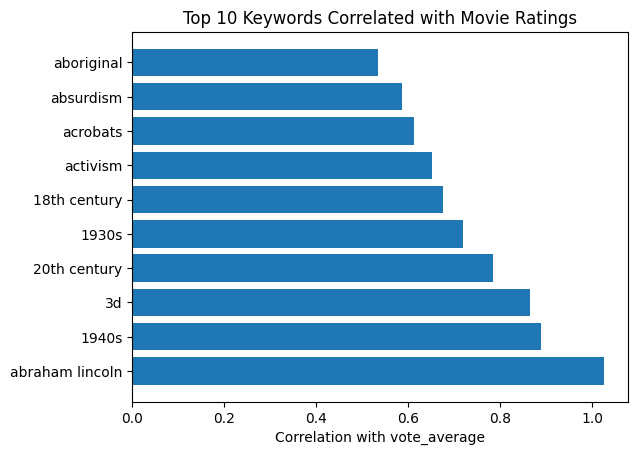

In [ ]:
top_keywords = sorted_keywords[:10]
keywords, scores = zip(*top_keywords)

plt.barh(keywords, scores)
plt.xlabel('Correlation with vote_average')
plt.title('Top 10 Keywords Correlated with Movie Ratings')
plt.show()

# 12. 모델 성능 평가

In [ ]:
from sklearn.metrics import r2_score

# 모델 예측 및 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


R² Score: 0.031469330813681196


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 3.609930802774298


# 13. 랜덤포레스트(Random Forest)

# 랜덤포레스트(Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. 모델 학습
rf_model.fit(X_train, y_train)

# 3. 예측
y_pred_rf = rf_model.predict(X_test)

# 4. 성능 평가 (R² 스코어와 MSE)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest R² Score: {r2_rf}")
print(f"Random Forest Mean Squared Error: {mse_rf}")

Random Forest R² Score: 0.03761432462367942
Random Forest Mean Squared Error: 3.5870270340622485


# XGBoost

In [ ]:
import xgboost as xgb

# 1. XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# 2. 모델 학습
xgb_model.fit(X_train, y_train)

# 3. 예측
y_pred_xgb = xgb_model.predict(X_test)

# 4. 성능 평가 (R² 스코어와 MSE)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost R² Score: {r2_xgb}")
print(f"XGBoost Mean Squared Error: {mse_xgb}")

XGBoost R² Score: 0.024309943372273435
XGBoost Mean Squared Error: 3.6366154438248963
